[naver api 사용하기](https://ericnjennifer.github.io/python_crawling/2018/01/05/PythonCrawling_Chapt4.html)  
[naver 데이터 수집하기](https://ericnjennifer.github.io/python_crawling/2018/01/21/PythonCrawling_Chapt9.html)  
[파이썬을 이용하여 naver 책 검색하기](https://wayhome25.github.io/python/2017/07/15/naver-search-api/)  
[파이썬으로 네이버 검색 API 요약문 수집 및 형태소 분석하기](http://kkwaks.net/920)  
[Naver Developers](https://developers.naver.com/docs/search/news/)  
[웹크롤링 - Open API(Rest API)를 활용한 크롤링](http://www.fun-coding.org/crawl_basic3.html)  
[통합 검색어 트랜드(naver)](https://developers.naver.com/docs/datalab/search/#%EA%B0%9C%EC%9A%94)  
[matplotlib](https://matplotlib.org/2.0.2/users/legend_guide.html)  
[Converting strings to Datatime](https://chrisalbon.com/python/basics/strings_to_datetime/)  
[Pandas from dict](http://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.from_dict.html)  
[matplotlib korean-1](http://pinkwink.kr/956)   
[matplotlib korean-2](http://corazzon.github.io/matplotlib_font_setting)  
아래 내용은 상기 링크를 정리한것.

# Naver Data Lap Crawling(using API)

주의사항  
* 하루 검색 기사수: API 호출 25000회/일로 제한.  
최대 한번에 100개의 검색을 가지고 있으므로 250,000건의 데이터를 가지고 올 수 있다.
* 검색 포인터 문제: 네이버 "탄핵"이라는 데이터를 검색하면 뉴스에서만 43만건이 검색되나 최대 1,000개 밖에 API를 이용하여 가지고 올 수 없다.(코드에서 설명)

In [7]:
import os
import sys
import urllib.request
import datetime
import time
import json
from configparser import *

In [13]:
#[CODE 1]

def get_request_url(url):
    
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", app_id)
    req.add_header("X-Naver-Client-Secret", app_secret)
    try: 
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print ("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None

#[CODE 2]

def getNaverSearchResult(sNode, search_text, page_start, display):
    
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % sNode
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(search_text), page_start, display)
    url = base + node + parameters
    
    retData = get_request_url(url)
    
    if (retData == None):
        return None
    else:
        return json.loads(retData)

#[CODE 3]

def getPostData(post, jsonResult):
    
    title = post['title']
    description = post['description']
    org_link = post['originallink']
    link = post['link']

    #Tue, 14 Feb 2017 18:46:00 +0900

    pDate = datetime.datetime.strptime(post['pubDate'],  '%a, %d %b %Y %H:%M:%S +0900')
    pDate = pDate.strftime('%Y-%m-%d %H:%M:%S')
    
    jsonResult.append({'title':title, 'description': description,
                    'org_link':org_link, 'link': org_link, 
                    'pDate':pDate})
    return    

def main():

    jsonResult = []

    # 'news', 'blog', 'cafearticle'

    sNode = 'news'
    search_text = '치킨'
    display_count = 10
    
    jsonSearch = getNaverSearchResult(sNode, search_text, 1, display_count)
    
    while ((jsonSearch != None) and (jsonSearch['display'] != 0)):
        for post in jsonSearch['items']:
            getPostData(post, jsonResult)
        
        nStart = jsonSearch['start'] + jsonSearch['display']
        jsonSearch = getNaverSearchResult(sNode, search_text, 1, 5)
    
    with open('%s_naver_%s.json' % (search_text, sNode), 'w', encoding='utf8') as outfile:
        retJson = json.dumps(jsonResult,
                        indent=4, sort_keys=True,
                        ensure_ascii=False)
        outfile.write(retJson)
        
    print ('%s_naver_%s.json SAVED' % (search_text, sNode))

    
if __name__ == '__main__':
    main()

[2018-06-14 20:33:47.780386] Url Request Success
[2018-06-14 20:33:47.850444] Url Request Success
[2018-06-14 20:33:47.930568] Url Request Success
[2018-06-14 20:33:48.012662] Url Request Success
[2018-06-14 20:33:48.099780] Url Request Success
[2018-06-14 20:33:48.184934] Url Request Success
[2018-06-14 20:33:48.248105] Url Request Success
[2018-06-14 20:33:48.469216] Url Request Success
[2018-06-14 20:33:48.523250] Url Request Success
[2018-06-14 20:33:48.594796] Url Request Success
[2018-06-14 20:33:48.677822] Url Request Success
[2018-06-14 20:33:48.765311] Url Request Success
[2018-06-14 20:33:48.825373] Url Request Success
[2018-06-14 20:33:48.888930] Url Request Success
HTTP Error 429: Too Many Requests
[2018-06-14 20:33:48.934490] Error for URL : https://openapi.naver.com/v1/search/news.json?query=%EC%B9%98%ED%82%A8&start=1&display=5
치킨_naver_news.json SAVED


# 데이터랩(크롤링)

주의사항 
* 통합 검색 트렌드 API의 하루 호출 한도 1000회를 주의

In [100]:
import os
import sys
import urllib.request
import json

def data_lap_(i, k):
    client_id = i
    client_secret = k
    url = "https://openapi.naver.com/v1/datalab/search";
    body = "{\"startDate\":\"2018-01-01\",\"endDate\":\"2018-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한국\",\"keywords\":[\"북한\",\"미국\"]},{\"groupName\":\"미국\",\"keywords\":[\"북한\",\"회담\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}";

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
#         print(response_body.decode('utf-8'))
        return response_body.decode('utf-8')
    else:
        print("Error Code:" + rescode)

In [101]:
data = data_lap_(,)
print(data)

{"startDate":"2018-01-01","endDate":"2018-04-30","timeUnit":"month","results":[{"title":"한국","keywords":["북한","미국"],"data":[{"period":"2018-01-01","ratio":44.08842},{"period":"2018-02-01","ratio":32.36462},{"period":"2018-03-01","ratio":51.98708},{"period":"2018-04-01","ratio":100}]},{"title":"미국","keywords":["북한","회담"],"data":[{"period":"2018-01-01","ratio":26.20466},{"period":"2018-02-01","ratio":17.80923},{"period":"2018-03-01","ratio":25.60854},{"period":"2018-04-01","ratio":68.45504}]}]}


In [255]:
type(data)

dict

In [107]:
data = json.loads(data)
type(data)

dict

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'], dtype='datetime64[ns]', freq=None)
[ 44.08842  32.36462  51.98708 100.     ]
[26.20466 17.80923 25.60854 68.45504]
한국 미국


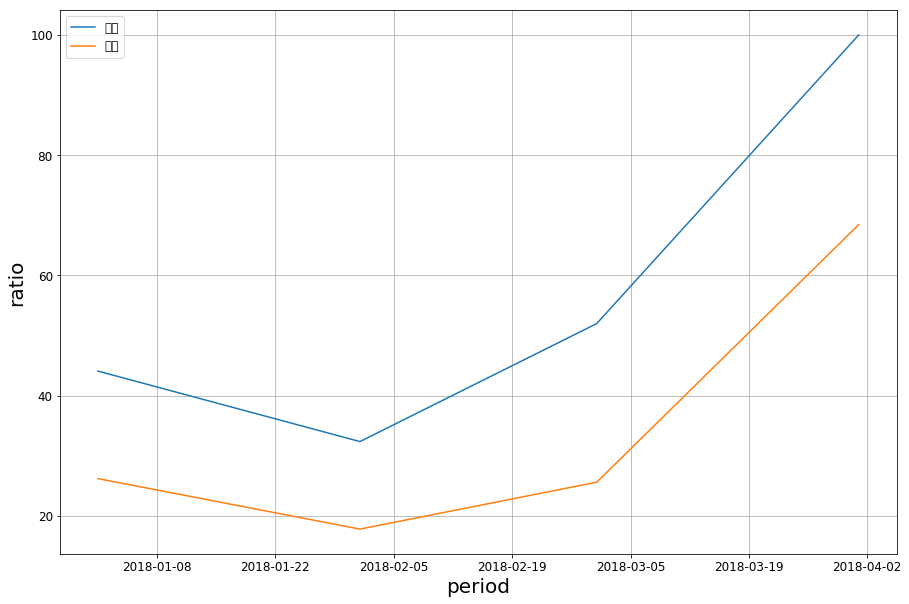

In [268]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt

x_1 = []
y_1 = []

x_2 = []
y_2 = []
 
for i in range(len(data['results'][0]['data'])):
#     print(i)
#     print(data['results'][i])
#     print(data['results'][i]['data'])
#     x = []
#     y = []
    
    x_1.append(data['results'][0]['data'][i]['period'])
    y_1.append(data['results'][0]['data'][i]['ratio'])
    
    x_2.append(data['results'][1]['data'][i]['period'])
    y_2.append(data['results'][1]['data'][i]['ratio'])
    
    

#     for j in range(len(data['results'][i]['data'])):
# #         print(data['results'][i]['data'][j])
# #         print(data['results'][i]['data'][j]['ratio'])
# #         print(data['results'][i]['data'][j]['period'])
#         date_fc = pandas.to_datetime(data['results'][i]['data'][j]['period'])
# #         value = pandas.to_numeric(data['results'][i]['data'][j]['ratio'])
#         x.append(data['results'][0]['data'][j]['period'])
#         y.append(data['results'][i]['data'][j]['ratio'])

#     print(type(value), value)
# print(x_1)
# print(y_1)
# date_fc = pandas.to_datetime(data['results'][0]['data'][i]['period'])

x_1 = pandas.to_datetime(x_1)
y_1 = pandas.to_numeric(y_1)
x_2 = pandas.to_datetime(x_2)
y_2 = pandas.to_numeric(y_2)
print(x_1)
print(x_2)
print(y_1)
print(y_2)
print(data['results'][0]['title'], data['results'][1]['title'])
plt.figure(figsize=(15,10))
plt.grid()
plt.plot(x_1, y_1, label = data['results'][0]['title'])
plt.plot(x_2, y_2, label = data['results'][1]['title'])
plt.rc('font', size=12)
plt.xlabel("period", fontsize=20)
plt.ylabel("ratio", fontsize=20)
plt.legend()
plt.show()

## 한글폰트 설정

matplotlib의 버전과 위치정보를 가져온다.

In [263]:
import matplotlib as mpl
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

버전:  2.2.2
설치 위치:  C:\Users\Andrew\AppData\Local\conda\conda\envs\text3.5\lib\site-packages\matplotlib\__init__.py
설정 위치:  C:\Users\Andrew\.matplotlib
캐시 위치:  C:\Users\Andrew\.matplotlib


matplotlib의 위치를 이용하여 터미널로 이동

In [259]:
print ('설정파일 위치: ', mpl.matplotlib_fname())

설정파일 위치:  C:\Users\Andrew\AppData\Local\conda\conda\envs\text3.5\lib\site-packages\matplotlib\mpl-data\matplotlibrc


설치된 폰트를 찍어본다.

In [262]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 

688


In [265]:
font_list_mac = fm.OSXInstalledFonts()
print(len(font_list_mac))


font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

0


NameError: name 'font_manager' is not defined